In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.calibration import _SigmoidCalibration
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve
from unittest.mock import patch

from scripts.evaluate_nested_cv_pac import calculate_metrics
from src.scripts.evaluate_nested_cv_pac import print_results

# Joint plot

In [3]:
# fold_indices_test = [0]  # for no outer CV
fold_indices_test = range(5)

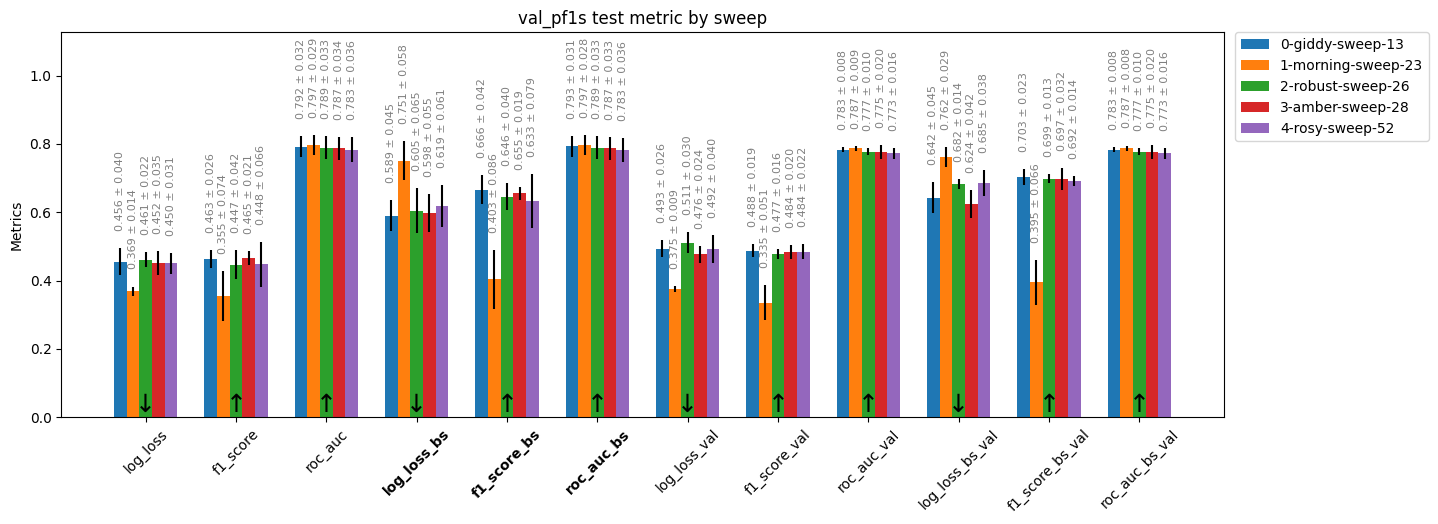

In [34]:
# plot matplotlib bar chart of mean metrics over fold_index_test
# with error bars of std over fold_index_test
# bars are grouped by metric_name, with one bar per sweep_name
#
# format is:
# results[fold_index_test][metric_name] float
# results is obtained as follows:
# for sweep_name in ['0-giddy-sweep-13', '1-morning-sweep-23']:
#     with open(f'/workspace/visiomel-2023/nested-kfold-checkpoints/{sweep_name}/cv_results.pkl', 'rb') as f:
#         results = pickle.load(f)
sweep_names = [
    '0-giddy-sweep-13', 
    '1-morning-sweep-23', 
    '2-robust-sweep-26',
    '3-amber-sweep-28',
    '4-rosy-sweep-52',
]
metric_optimized = 'val_pf1s'

sweep_results = defaultdict(dict)
for sweep_name in sweep_names:
    with open(f'/workspace/visiomel-2023/nested-kfold-checkpoints/{metric_optimized}/{sweep_name}/cv_results.pkl', 'rb') as f:
        results = pickle.load(f)
    
    # calculate mean and std over fold_index_test
    mean_results = {}
    std_results = {}
    for fold_index_test in fold_indices_test:
        for metric_name in results[fold_index_test]:
            if metric_name == 'data':
                continue
            if metric_name not in mean_results:
                mean_results[metric_name] = []
                std_results[metric_name] = []
            mean_results[metric_name].append(results[fold_index_test][metric_name])
            std_results[metric_name].append(results[fold_index_test][metric_name])
    
    for metric_name in mean_results:
        mean_results[metric_name] = np.mean(mean_results[metric_name])
        std_results[metric_name] = np.std(std_results[metric_name])

        sweep_results[metric_name][sweep_name] = {
            'mean': mean_results[metric_name],
            'std': std_results[metric_name]
        }
    
# plot
fig, ax = plt.subplots(figsize=(15, 5))
n_sweeps = len(sweep_names)
width = 0.7 / n_sweeps
x = np.arange(len(sweep_results))
for i, metric_name in enumerate(sweep_results):
    for j, sweep_name in enumerate(sweep_results[metric_name]):
        mean_results, std_results = sweep_results[metric_name][sweep_name].values()
        shift = width * j - width * (n_sweeps / 2 - 0.5)
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][j]
        label = None
        if i == 0:
            label = sweep_name
        ax.bar(
            x[i] + shift, 
            mean_results, 
            width, 
            label=label, 
            yerr=std_results, color=color
        )
        # add vertical text with mean +- std metric to the top of each bar
        ax.text(
            x[i] + shift,
            mean_results + std_results + 0.05,
            f'{mean_results:.3f} ± {std_results:.3f}',
            ha='left',
            va='center',
            fontsize=8,
            rotation=90,
            rotation_mode='anchor',
            alpha=0.5
        )

# extend y axis to include error bars and text
ax.set_ylim([None, 1.3 * ax.get_ylim()[1]])

ax.set_ylabel('Metrics')
ax.set_title(f'{metric_optimized} test metric by sweep')
ax.set_xticks(x)
ax.set_xticklabels(sweep_results.keys())
# rotate x tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
# - underline '*bs' x tick label
# - add arrow down to 'log_loss*' x tick label 
#   and arrow up to other x tick labels
for label in ax.get_xticklabels():
    if label.get_text().endswith('bs'):
        label.set_fontweight('bold')
    if label.get_text().startswith('log_loss'):
        direction = '↓'
    else:
        direction = '↑'
    ax.annotate(
        direction, 
        xy=(label.get_position()[0], label.get_position()[1]), 
        ha='center', 
        va='bottom', 
        fontsize=18
    )
# add legend outside of plot
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Single sweep

In [3]:
# sweep_name = '0-giddy-sweep-13'
sweep_name = '1-morning-sweep-23'

In [4]:
with open(f'/workspace/visiomel-2023/nested-kfold-checkpoints/{sweep_name}/cv_results.pkl', 'rb') as f:
    results = pickle.load(f)

In [5]:
print_results(results)

Fold 0
	log_loss: 0.3669467326650687
	f1_score: 0.3103448275862069
	roc_auc: 0.7969746861494135
	log_loss_bs: 0.7823247747411493
	f1_score_bs: 0.33886128264320914
	roc_auc_bs: 0.7991730665224445
	log_loss_val: 0.37712943835402496
	f1_score_val: 0.26589030276437037
	roc_auc_val: 0.7776352444543865
	log_loss_bs_val: 0.8064965876946022
	f1_score_bs_val: 0.29384283753079715
	roc_auc_bs_val: 0.77788581036375

Fold 1
	log_loss: 0.3695843865538074
	f1_score: 0.30769230769230765
	roc_auc: 0.8097157622739017
	log_loss_bs: 0.7068101328182533
	f1_score_bs: 0.36175097322541017
	roc_auc_bs: 0.8081389940508383
	log_loss_val: 0.3687364029440731
	f1_score_val: 0.4152663935131578
	roc_auc_val: 0.785306304842379
	log_loss_bs_val: 0.7218485261321379
	f1_score_bs_val: 0.4833780434070035
	roc_auc_bs_val: 0.7860161764705882

Fold 2
	log_loss: 0.3874852229973224
	f1_score: 0.27118644067796605
	roc_auc: 0.7610619469026549
	log_loss_bs: 0.8299695738238951
	f1_score_bs: 0.3100825861872138
	roc_auc_bs: 0.7627721

In [5]:
for fold_index_test in fold_indices_test:
    if fold_index_test not in results:
        print(f'Outer fold {fold_index_test} not found')
        continue
    for fold_index in range(5):
        if fold_index not in results[fold_index_test]['data']['pac']:
            print(f'Fold {fold_index} not found')
            continue

class: no relapse, fold: 0, mean: 0.26727139949798584, min: 0.09942630678415298, max: 0.8556890487670898
class: relapse, fold: 0, mean: 0.5079376101493835, min: 0.11550810188055038, max: 0.8499826192855835


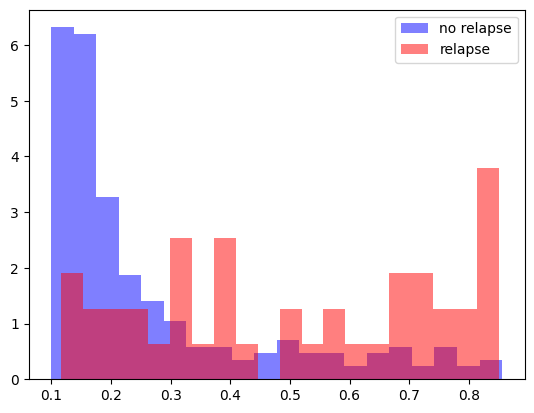

class: no relapse, fold: 1, mean: 0.3120577335357666, min: 0.08224377781152725, max: 0.8754751086235046
class: relapse, fold: 1, mean: 0.5591122508049011, min: 0.11529441922903061, max: 0.8794881701469421


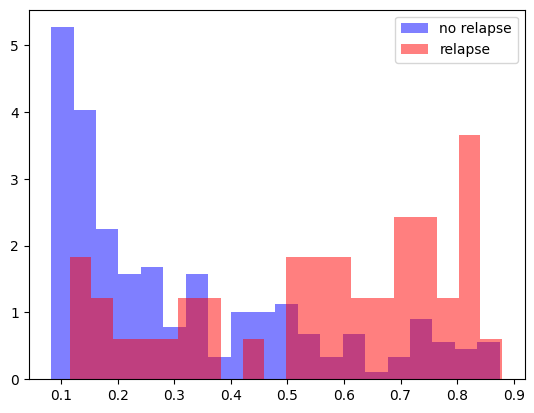

class: no relapse, fold: 2, mean: 0.27608728408813477, min: 0.04927805811166763, max: 0.8852384686470032
class: relapse, fold: 2, mean: 0.5256195068359375, min: 0.05844050645828247, max: 0.8984384536743164


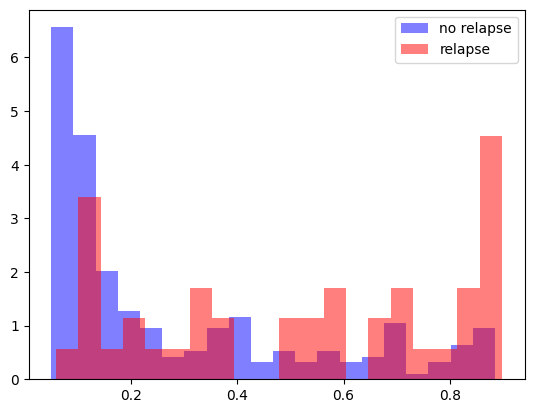

class: no relapse, fold: 3, mean: 0.26119905710220337, min: 0.06305690854787827, max: 0.8580365180969238
class: relapse, fold: 3, mean: 0.5581126809120178, min: 0.07356163114309311, max: 0.8616668581962585


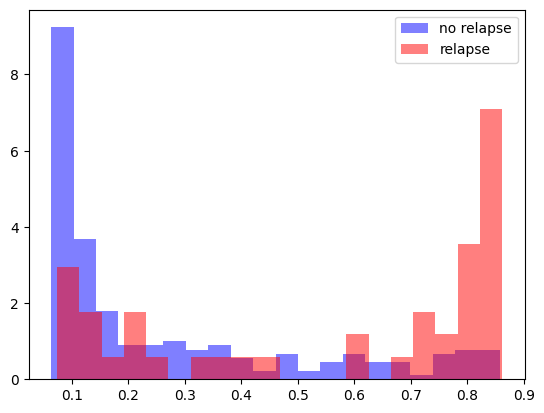

class: no relapse, fold: 4, mean: 0.2372623234987259, min: 0.046382706612348557, max: 0.8710315823554993
class: relapse, fold: 4, mean: 0.5866380929946899, min: 0.054854799062013626, max: 0.8748737573623657


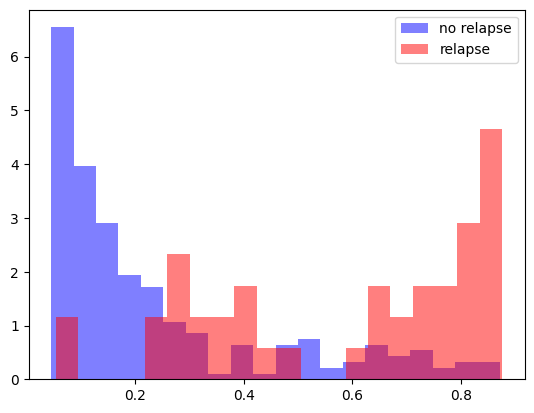

In [6]:
# plot hists of probabilities for class 0 and 1
# for each fold
# probs of class 1: results[fold_index]['data']['pac']['mean']
# gt: results[fold_index]['data']['gt']
# fold_index: 0, 1, 2, 3, 4
# class_index: 0, 1
# class_name: 'no relapse', 'relapse'
# class_color: 'blue', 'red'

if fold_indices_test is not None:
    for fold_index_test in fold_indices_test:
        for class_index in range(2):
            class_name = ['no relapse', 'relapse'][class_index]
            class_color = ['blue', 'red'][class_index]
            probs = \
                (results[fold_index_test]['data']['pac']['mean'])
            gt = results[fold_index_test]['data']['gt']
            plt.hist(probs[gt == class_index], bins=20, density=True, color=class_color, alpha=0.5, label=class_name)
            print(f'class: {class_name}, fold: {fold_index_test}, mean: {probs[gt == class_index].mean()}, min: {probs[gt == class_index].min()}, max: {probs[gt == class_index].max()}')
        plt.legend()
        plt.show()

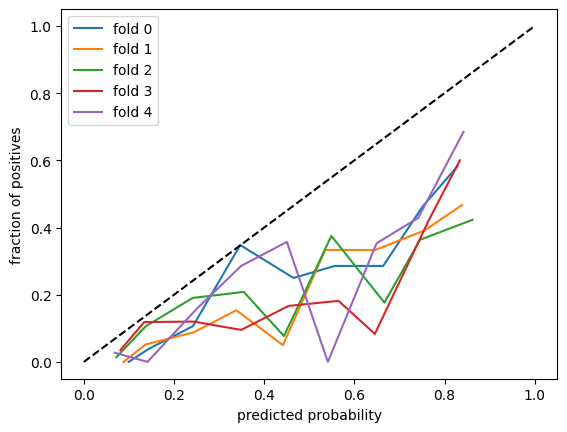

In [7]:
# plot calibration curves
# for each fold
# probs of class 1: results[fold_index]['data']['pac']['mean']
# gt: results[fold_index]['data']['gt']
# fold_index: 0, 1, 2, 3, 4
# class_index: 0, 1
# class_name: 'no relapse', 'relapse'
# class_color: 'blue', 'red'
if fold_indices_test is not None:
    for fold_index_test in fold_indices_test:
        prob_true, prob_pred = calibration_curve(
            results[fold_index_test]['data']['gt'],
            results[fold_index_test]['data']['pac']['mean'],
            n_bins=10,
            strategy='uniform',
        )
        plt.plot(prob_pred, prob_true, label=f'fold {fold_index_test}')
    plt.xlabel('predicted probability')
    plt.ylabel('fraction of positives')
    plt.legend()
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')

## Calibration

### Default sigmoid

In [8]:
if fold_indices_test is not None:
    method = "sigmoid"
    for fold_index_test in fold_indices_test:
        for fold_index in range(5):
            y_proba_val = results[fold_index_test]['data']['pac'][fold_index]['y_proba_val']
            y_val = results[fold_index_test]['data']['pac'][fold_index]['gt_val']

            class_idx = 1
            if method == "isotonic":
                calibrator = IsotonicRegression(out_of_bounds="clip")
            else:  # "sigmoid"
                calibrator = _SigmoidCalibration()
            calibrator.fit(y_proba_val, y_val, None)

            # recalculate probabilities
            results[fold_index_test]['data']['pac'][fold_index]['y_proba_test_calibrated'] = \
                calibrator.predict(results[fold_index_test]['data']['pac'][fold_index]['y_proba_test'])
        results[fold_index_test]['data']['pac']['mean_calibrated'] = \
            sum(results[fold_index_test]['data']['pac'][fold_index]['y_proba_test_calibrated'] for fold_index in range(5)) / 5

In [9]:
calibrator.a_, calibrator.b_

(-2.834281077643826, 2.587888595799156)

class: no relapse, fold: 0, mean: 0.13324129581451416, min: 0.05596504732966423, max: 0.5771997570991516
class: relapse, fold: 0, mean: 0.2886619567871094, min: 0.05975113436579704, max: 0.5715764164924622


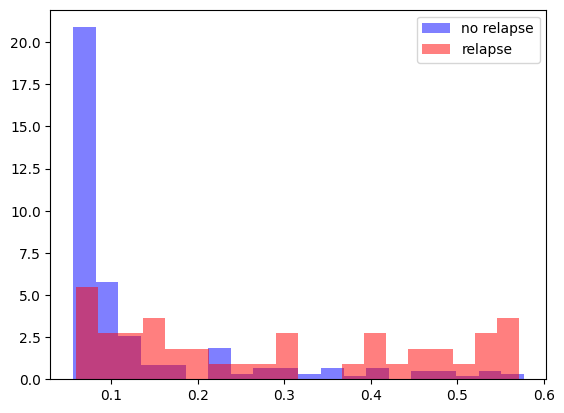

class: no relapse, fold: 1, mean: 0.14831458032131195, min: 0.051470302045345306, max: 0.5093474388122559
class: relapse, fold: 1, mean: 0.2821923494338989, min: 0.05793444439768791, max: 0.5111533403396606


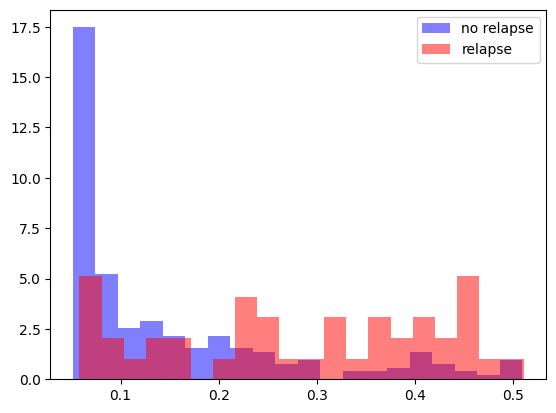

class: no relapse, fold: 2, mean: 0.14261572062969208, min: 0.04814191907644272, max: 0.5050413012504578
class: relapse, fold: 2, mean: 0.27628183364868164, min: 0.04931790754199028, max: 0.5169557929039001


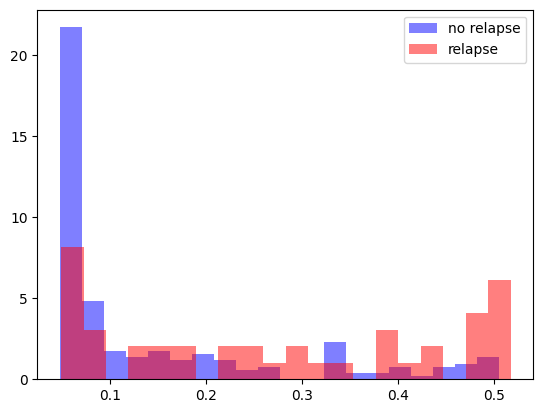

class: no relapse, fold: 3, mean: 0.12714923918247223, min: 0.04908100143074989, max: 0.4603798985481262
class: relapse, fold: 3, mean: 0.28083279728889465, min: 0.05089659243822098, max: 0.4635874330997467


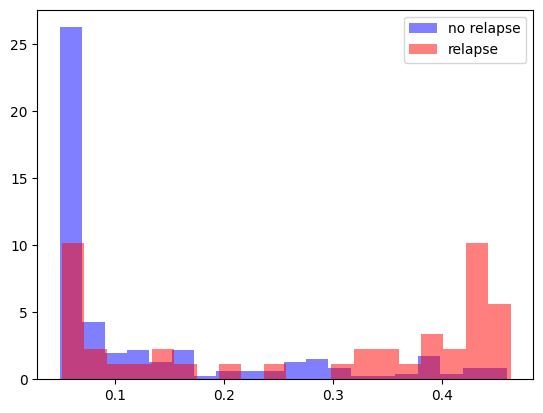

class: no relapse, fold: 4, mean: 0.1287851184606552, min: 0.05984367057681084, max: 0.474203884601593
class: relapse, fold: 4, mean: 0.2954293489456177, min: 0.061162661761045456, max: 0.4744643568992615


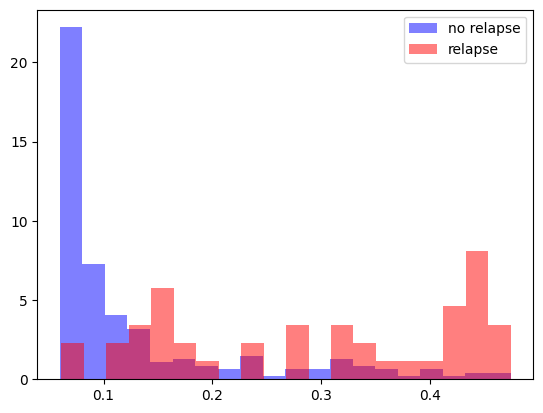

In [10]:
# plot hists of probabilities for class 0 and 1
# for each fold
# probs of class 1: results[fold_index]['data']['pac']['mean']
# gt: results[fold_index]['data']['gt']
# fold_index: 0, 1, 2, 3, 4
# class_index: 0, 1
# class_name: 'no relapse', 'relapse'
# class_color: 'blue', 'red'

if fold_indices_test is not None:
    for fold_index_test in fold_indices_test:
        for class_index in range(2):
            class_name = ['no relapse', 'relapse'][class_index]
            class_color = ['blue', 'red'][class_index]
            probs = \
                (results[fold_index_test]['data']['pac']['mean_calibrated'])
            gt = results[fold_index_test]['data']['gt']
            plt.hist(probs[gt == class_index], bins=20, density=True, color=class_color, alpha=0.5, label=class_name)
            print(f'class: {class_name}, fold: {fold_index_test}, mean: {probs[gt == class_index].mean()}, min: {probs[gt == class_index].min()}, max: {probs[gt == class_index].max()}')
        plt.legend()
        plt.show()

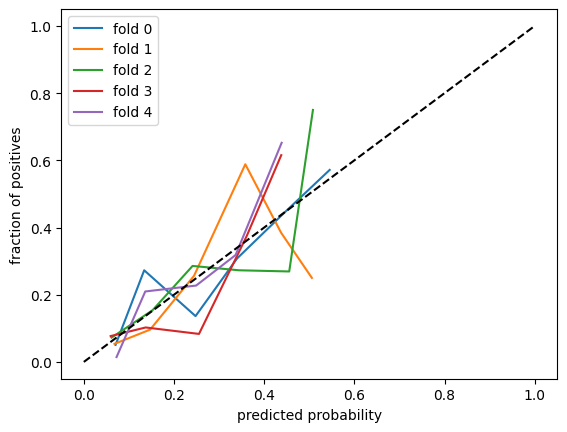

In [11]:
# plot calibration curves
# for each fold
# probs of class 1: results[fold_index]['data']['pac']['mean']
# gt: results[fold_index]['data']['gt']
# fold_index: 0, 1, 2, 3, 4
# class_index: 0, 1
# class_name: 'no relapse', 'relapse'
# class_color: 'blue', 'red'
if fold_indices_test is not None:
    for fold_index_test in fold_indices_test:
        prob_true, prob_pred = calibration_curve(
            results[fold_index_test]['data']['gt'],
            results[fold_index_test]['data']['pac']['mean_calibrated'],
            n_bins=10,
            strategy='uniform',
        )
        plt.plot(prob_pred, prob_true, label=f'fold {fold_index_test}')
    plt.xlabel('predicted probability')
    plt.ylabel('fraction of positives')
    plt.legend()
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')

In [15]:
if fold_indices_test is not None:
    n_bootstrap = 1000
    for fold_index_test in fold_indices_test:
        data = results[fold_index_test]['data']
        
        # Metrics
        results[fold_index_test].update(
            {
                metric_name + '_calibrated': metric_value
                for metric_name, metric_value in calculate_metrics(
                    data['gt'], 
                    data['pac']['mean_calibrated'], 
                    n_bootstrap=n_bootstrap
                ).items()
            }
        )

In [16]:
print_results(results)

Fold 0
	log_loss: 0.43841182224537617
	f1_score: 0.4375
	roc_auc: 0.7892570487754682
	log_loss_bs: 0.5935543546681198
	f1_score_bs: 0.6006399545634203
	roc_auc_bs: 0.7917517577068686
	log_loss_val: 0.44696049399778043
	f1_score_val: 0.5067874238751771
	roc_auc_val: 0.7915403048545719
	log_loss_bs_val: 0.597071405243426
	f1_score_bs_val: 0.6823190142533994
	roc_auc_bs_val: 0.791706849792907
	log_loss_calibrated: 0.36751349864527944
	f1_score_calibrated: 0.2807017543859649
	roc_auc_calibrated: 0.792138300061741
	log_loss_bs_calibrated: 0.8184782951612757
	f1_score_bs_calibrated: 0.3070659282186357
	roc_auc_bs_calibrated: 0.7932671714440238

Fold 1
	log_loss: 0.4961205783996079
	f1_score: 0.4878048780487806
	roc_auc: 0.7781912144702843
	log_loss_bs: 0.5828800676574177
	f1_score_bs: 0.7272982873503661
	roc_auc_bs: 0.7779588967009194
	log_loss_val: 0.4892749782489941
	f1_score_val: 0.4722735482577979
	roc_auc_val: 0.7814778102769653
	log_loss_bs_val: 0.6296647821946857
	f1_score_bs_val: 0.6

### No-bias sigmoid

In [41]:
import numpy as np
from math import log
from sklearn.calibration import column_or_1d, expit, fmin_bfgs, xlogy


def _sigmoid_calibration_no_bias(predictions, y, sample_weight=None):
    """Probability Calibration with sigmoid method (Platt 2000)

    Parameters
    ----------
    predictions : ndarray of shape (n_samples,)
        The decision function or predict proba for the samples.

    y : ndarray of shape (n_samples,)
        The targets.

    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights. If None, then samples are equally weighted.

    Returns
    -------
    a : float
        The slope.

    b : float
        The intercept.

    References
    ----------
    Platt, "Probabilistic Outputs for Support Vector Machines"
    """
    predictions = column_or_1d(predictions)
    y = column_or_1d(y)

    F = predictions  # F follows Platt's notations

    # Bayesian priors (see Platt end of section 2.2):
    # It corresponds to the number of samples, taking into account the
    # `sample_weight`.
    mask_negative_samples = y <= 0
    if sample_weight is not None:
        prior0 = (sample_weight[mask_negative_samples]).sum()
        prior1 = (sample_weight[~mask_negative_samples]).sum()
    else:
        prior0 = float(np.sum(mask_negative_samples))
        prior1 = y.shape[0] - prior0
    T = np.zeros_like(y, dtype=np.float64)
    T[y > 0] = (prior1 + 1.0) / (prior1 + 2.0)
    T[y <= 0] = 1.0 / (prior0 + 2.0)
    T1 = 1.0 - T

    def objective(A):
        # From Platt (beginning of Section 2.2)
        P = expit(-(A[0] * F + 0))
        loss = -(xlogy(T, P) + xlogy(T1, 1.0 - P))
        if sample_weight is not None:
            return (sample_weight * loss).sum()
        else:
            return loss.sum()

    def grad(A):
        # gradient of the objective function
        P = expit(-(A[0] * F + 0))
        TEP_minus_T1P = T - P
        if sample_weight is not None:
            TEP_minus_T1P *= sample_weight
        dA = np.dot(TEP_minus_T1P, F)
        return np.array([dA])

    A0 = np.array([0.0,])
    A_ = fmin_bfgs(objective, A0, fprime=grad, disp=False)
    print(A_)
    return A_[0], 0.0

def _sigmoid_calibration2(predictions, y, sample_weight=None):
    """Probability Calibration with sigmoid method (Platt 2000)

    Parameters
    ----------
    predictions : ndarray of shape (n_samples,)
        The decision function or predict proba for the samples.

    y : ndarray of shape (n_samples,)
        The targets.

    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights. If None, then samples are equally weighted.

    Returns
    -------
    a : float
        The slope.

    b : float
        The intercept.

    References
    ----------
    Platt, "Probabilistic Outputs for Support Vector Machines"
    """
    predictions = column_or_1d(predictions)
    y = column_or_1d(y)

    F = predictions  # F follows Platt's notations

    # Bayesian priors (see Platt end of section 2.2):
    # It corresponds to the number of samples, taking into account the
    # `sample_weight`.
    mask_negative_samples = y <= 0
    if sample_weight is not None:
        prior0 = (sample_weight[mask_negative_samples]).sum()
        prior1 = (sample_weight[~mask_negative_samples]).sum()
    else:
        prior0 = float(np.sum(mask_negative_samples))
        prior1 = y.shape[0] - prior0
    T = np.zeros_like(y, dtype=np.float64)
    T[y > 0] = (prior1 + 1.0) / (prior1 + 2.0)
    T[y <= 0] = 1.0 / (prior0 + 2.0)
    T1 = 1.0 - T

    def objective(AB):
        # From Platt (beginning of Section 2.2)
        P = expit(-(AB[0] * F + AB[1]))
        loss = -(xlogy(T, P) + xlogy(T1, 1.0 - P))
        if sample_weight is not None:
            return (sample_weight * loss).sum()
        else:
            return loss.sum()

    def grad(AB):
        # gradient of the objective function
        P = expit(-(AB[0] * F + AB[1]))
        TEP_minus_T1P = T - P
        if sample_weight is not None:
            TEP_minus_T1P *= sample_weight
        dA = np.dot(TEP_minus_T1P, F)
        dB = np.sum(TEP_minus_T1P)
        return np.array([dA, dB])

    AB0 = np.array([0.0, log((prior0 + 1.0) / (prior1 + 1.0))])
    AB_ = fmin_bfgs(objective, AB0, fprime=grad, disp=False)
    print(AB_)
    return AB_[0], 0

In [42]:
if fold_indices_test is not None:
    # with patch('sklearn.calibration._sigmoid_calibration', _sigmoid_calibration_no_bias):
    with patch('sklearn.calibration._sigmoid_calibration', _sigmoid_calibration2):
        method = "sigmoid"
        for fold_index_test in fold_indices_test:
            for fold_index in range(5):
                y_proba_val = results[fold_index_test]['data']['pac'][fold_index]['y_proba_val']
                y_val = results[fold_index_test]['data']['pac'][fold_index]['gt_val']

                class_idx = 1
                if method == "isotonic":
                    calibrator = IsotonicRegression(out_of_bounds="clip")
                else:  # "sigmoid"
                    calibrator = _SigmoidCalibration()
                calibrator.fit(y_proba_val, y_val, None)

                # recalculate probabilities
                results[fold_index_test]['data']['pac'][fold_index]['y_proba_test_calibrated_no_bias'] = \
                    calibrator.predict(results[fold_index_test]['data']['pac'][fold_index]['y_proba_test'])
            results[fold_index_test]['data']['pac']['mean_calibrated_no_bias'] = \
                sum(results[fold_index_test]['data']['pac'][fold_index]['y_proba_test_calibrated_no_bias'] for fold_index in range(5)) / 5

[-4.2634914   3.40021069]
[-3.88154027  2.98087872]
[-4.96808068  3.16089189]
[-3.82122007  3.24789897]
[-4.09447254  3.5621765 ]
[-2.83638529  2.59651986]
[-3.96909313  3.25108305]
[-4.64405378  3.96072783]
[-4.33910932  3.78028205]
[-3.4984249   2.97602699]
[-4.19014401  4.02759323]
[-3.92354739  3.30598771]
[-4.37920802  3.03623   ]
[-2.68779276  2.60455433]
[-3.44254859  3.28735443]
[-2.83643907  2.79958292]
[-3.13402414  3.08229763]
[-4.2548466   3.73455107]
[-3.72462384  3.06137786]
[-3.96901452  3.45216921]
[-2.73617889  2.86018495]
[-3.39578211  3.07452154]
[-6.47139114  4.50972319]
[-2.01748953  2.32280782]
[-2.83428108  2.5878886 ]


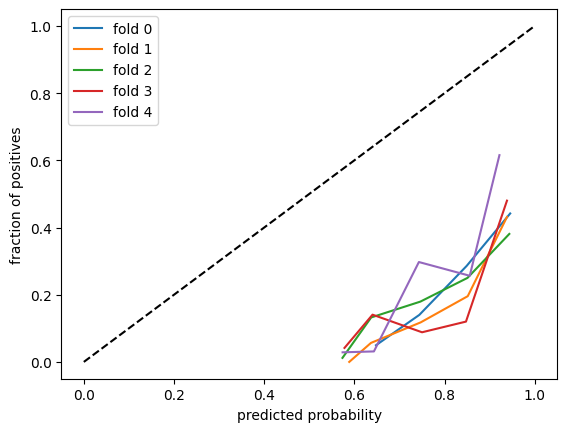

In [43]:
# plot calibration curves
# for each fold
# probs of class 1: results[fold_index]['data']['pac']['mean']
# gt: results[fold_index]['data']['gt']
# fold_index: 0, 1, 2, 3, 4
# class_index: 0, 1
# class_name: 'no relapse', 'relapse'
# class_color: 'blue', 'red'
if fold_indices_test is not None:
    for fold_index_test in fold_indices_test:
        prob_true, prob_pred = calibration_curve(
            results[fold_index_test]['data']['gt'],
            results[fold_index_test]['data']['pac']['mean_calibrated_no_bias'],
            n_bins=10,
            strategy='uniform',
        )
        plt.plot(prob_pred, prob_true, label=f'fold {fold_index_test}')
    plt.xlabel('predicted probability')
    plt.ylabel('fraction of positives')
    plt.legend()
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')

In [44]:
if fold_indices_test is not None:
    n_bootstrap = 1000
    for fold_index_test in fold_indices_test:
        data = results[fold_index_test]['data']
        
        # Metrics
        results[fold_index_test].update(
            {
                metric_name + '_calibrated_no_bias': metric_value
                for metric_name, metric_value in calculate_metrics(
                    data['gt'], 
                    data['pac']['mean_calibrated_no_bias'], 
                    n_bootstrap=n_bootstrap
                ).items()
            }
        )

In [45]:
print_results(results)

Fold 0
	log_loss: 0.43841182224537617
	f1_score: 0.4375
	roc_auc: 0.7892570487754682
	log_loss_bs: 0.5935543546681198
	f1_score_bs: 0.6006399545634203
	roc_auc_bs: 0.7917517577068686
	log_loss_val: 0.44696049399778043
	f1_score_val: 0.5067874238751771
	roc_auc_val: 0.7915403048545719
	log_loss_bs_val: 0.597071405243426
	f1_score_bs_val: 0.6823190142533994
	roc_auc_bs_val: 0.791706849792907
	log_loss_calibrated: 0.36751349864527944
	f1_score_calibrated: 0.2807017543859649
	roc_auc_calibrated: 0.792138300061741
	log_loss_bs_calibrated: 0.8184782951612757
	f1_score_bs_calibrated: 0.3070659282186357
	roc_auc_bs_calibrated: 0.7932671714440238
	log_loss_calibrated_no_bias: 1.20688208255573
	f1_score_calibrated_no_bias: 0.2756410256410256
	roc_auc_calibrated_no_bias: 0.7881251286272896
	log_loss_bs_calibrated_no_bias: 0.7871597796071066
	f1_score_bs_calibrated_no_bias: 0.6666666666666665
	roc_auc_bs_calibrated_no_bias: 0.7901595457003785

Fold 1
	log_loss: 0.4961205783996079
	f1_score: 0.4878

: 